In [1]:
import csv
import webcolors 
import colorsys
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatch

In [2]:
# helper functions

def hls_to_rgb_hex(h_base,l_value,s_value):
    return webcolors.rgb_to_hex([int(x*255.0) for x in colorsys.hls_to_rgb(h_base, l_value, s_value)])

In [3]:
def plot_palette(df):
    ## plot

    fig = plt.figure(figsize=[16, 16])
    ax = fig.add_axes([0, 0, 1, 1])

    for index, row in df.iterrows():

        plot_x = row['area_code']-1
        plot_y = 25-row['color_code']

        r1 = mpatch.Rectangle((plot_x, plot_y), 1, 1, color=row['color_hex'])
        ax.add_patch(r1)
        # ax.add_patch(r2)

        if row['color_hex'] ==  row['color_continent']:
             ax.axvline(plot_x, color='k')
             ax.text(plot_x+0.5, 25.5,  row['continent_label'], va='center', fontsize=14)

        if row['color_hex'] ==  row['color_area']:
            ax.text(plot_x+0.2, plot_y+0.5,  row['hue'], va='center', fontsize=11)
            
    ax.set_xlim(0, 22)
    ax.set_ylim(0, 26)
    ax.axis('off')
    
    return plt

In [4]:
def gen_gco_palette_pd(h_value, h_area_span, l_value, s_value):
    base_arr =[[1, "Africa", 5], [2, "America", 4], [4, "Asia",4], [5, "Europe",4],[6, "Oceania",5]]

    bdf = pd.DataFrame(base_arr, columns = ['continent_code', 'continent_label', 'subs'])
    
#     print(bdf)

    s_value_p, l_value_p, index_p, sub_p = pd.core.reshape.util.cartesian_product(
        [s_value, l_value, range(len(bdf)),range(bdf['subs'].max())])
    df2 = pd.DataFrame(dict(s_value=s_value_p, l_value=l_value_p, continent_index=index_p, sub=sub_p ))
    
#     print(df2)
    
    df2['continent_code']  = df2['continent_index'].apply(lambda index: bdf.iloc[index][0])
    df2 = df2.merge(bdf, on='continent_code')

    df2 = df2.drop(df2[(df2['sub']>=df2['subs'])].index)

    df2['h_base'] = df2['continent_index'].apply(lambda index: h_value[index])
    df2['h_span'] = df2['continent_index'].apply(lambda index: h_area_span[index])
    df2['color_continent'] = df2['h_base'].apply(lambda h_base: hls_to_rgb_hex(h_base, l_value[0], s_value[0]))

    df2['h_base_area'] = df2.apply(lambda row: row['h_base'] + (row['h_span'] * row['sub']), axis=1)
    df2['color_area']  = df2.apply(lambda row: hls_to_rgb_hex(row['h_base_area'], l_value[0], s_value[0]), axis = 1)
    df2['color_hex']   = df2.apply(lambda row: hls_to_rgb_hex(row['h_base_area'],  row['l_value'], row['s_value']), axis=1)
    df2['color_code']  = df2.groupby(['continent_code','sub']).cumcount() + 1
    df2['area_code']   = df2.groupby(['l_value','s_value']).cumcount() + 1

    df2['hue'] = round(df2['h_base_area'],2)
    return df2

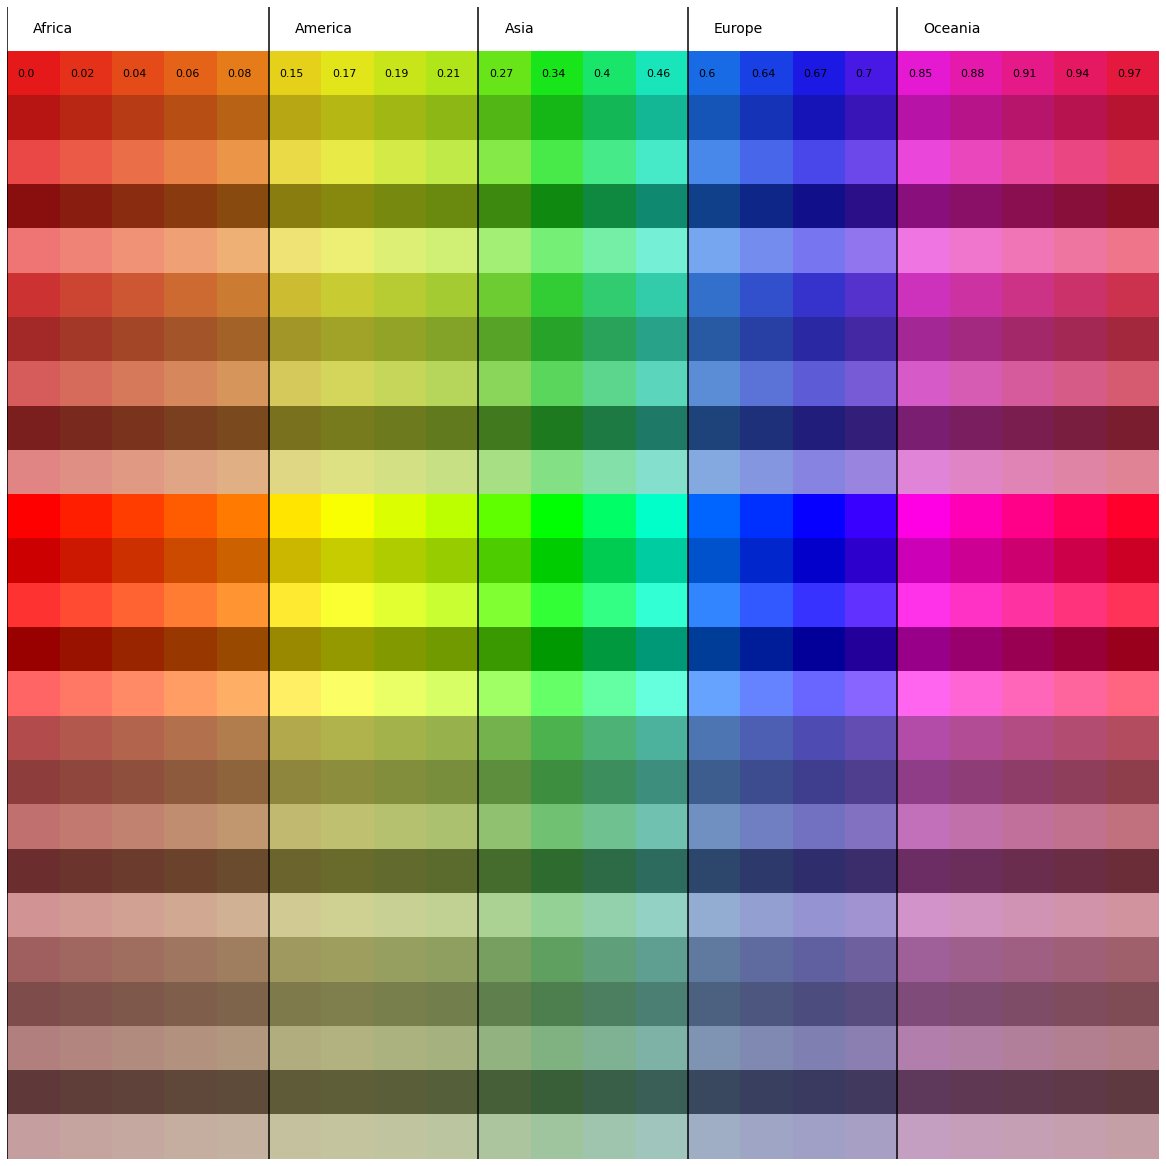

In [9]:
hue_continent = [0,0.15,0.27,0.60,0.85]
hue_area_span = [0.02,0.02,0.065,0.035,0.03]
lightness_value =  [0.5,0.4,0.6,0.3,0.7]
saturation_value = [0.8,0.6,1,0.4,0.25]

df_palette_pd = gen_gco_palette_pd(hue_continent, hue_area_span, lightness_value, saturation_value)
df_palette_pd['h_base_area'] = round(df_palette_pd['h_base_area'],2)
plot_palette(df_palette_pd).show()

In [10]:
# export color code to csv 
df_palette_pd.to_csv('color_gco_country.csv', index=False)